<a href="https://colab.research.google.com/github/Lambda-School-Labs/Labs26-Citrics-DS-TeamC/blob/mtoce/notebooks/Weather_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driftly Weather Notebook

## Import and Install Required Packages

In [1]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import urllib.request
import urllib
import urllib.parse
import os
import requests
from datetime import datetime
# import prettytable
import seaborn as sns
# import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pip install wwo-hist

In [3]:
from wwo_hist import retrieve_hist_data

In [4]:
capitals_list = ['Albany','Annapolis','Atlanta','Augusta','Austin','Baton_Rouge','Bismarck','Boise','Boston','Carson_City','Charleston','Cheyenne','Columbia','Columbus','Concord','Denver','Des_Moines','Dover','Frankfort','Harrisburg','Hartford','Helena','Honolulu','Indianapolis','Jackson','Jefferson_City','Juneau','Lansing','Lincoln','LittleRock','Madison','Montgomery','Montpelier','Nashville','Oklahoma_City','Olympia','Phoenix','Pierre','Providence','Raleigh','Richmond','Sacramento','Saint_Paul','Salem','Salt_Lake_City','Santa_Fe_USA','Springfield','Tallahassee','Topeka','Trenton']

states_list = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New_Hampshire','New_Jersey','New Mexico','New_York','North_Carolina','North_Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode_Island','South_Carolina','South_Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West_Virginia','Wisconsin','Wyoming']

In [5]:
# Got stopped because of query limit and need to query these cities still as of 9/08
capitals_list_retry = ['Santa_Fe_USA','Trenton']

## Data Aggregation using WWO API

In [6]:
# # USING THE API
# #########################################################
# frequency = 24  # time between each data row (hours) - max of 24
# start_date = '01-JAN-2015'
# end_date = '31-DEC-2018'
# free_trial_api_key = '831e61eaec474f5ca63202520200309'
# new_api_key = 'ddd3168a425b434f828201815200309'
# location_list = ['Santa_Fe_USA','Trenton']
# hist_weather_data = retrieve_hist_data(new_api_key,
#                                 location_list,
#                                 start_date,
#                                 end_date,
#                                 frequency,
#                                 location_label = False,
#                                 export_csv = True,
#                                 store_df = True)

## Clean the Data for Predictive Modeling

In [7]:
## FOR COLLAB USE

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEFercao3-dlwK5Ki7_wCzij9dfxSXCoKN28qqHe_Dq8UZ_yqDJFCM
Mounted at /content/drive


In [62]:
import pandas as pd
import glob

local_path = r'C:\Users\Mike\LambdaSchool\labs\Labs26-Citrics-DS-TeamC\data\weather'
collab_path = r'/content/drive/My Drive/Lambda/weather'

all_files = glob.glob(collab_path + "/*.csv")

list_ = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_.append(df)

data = pd.concat(list_, axis=0, ignore_index=True)
data.tail()

,Unnamed: 0,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
91345,1822,2019-12-28,12,7,0.0,8.7,3,8,09:37 AM,08:01 PM,07:32 AM,05:29 PM,1,7,9,7,23,25,61,1.3,1015,12,10,264,16,Phoenix_AZ
91346,1823,2019-12-29,11,5,0.0,8.7,3,15,10:17 AM,08:58 PM,07:32 AM,05:29 PM,-2,7,9,7,7,10,48,0.0,1022,11,10,119,5,Phoenix_AZ
91347,1824,2019-12-30,12,5,0.0,5.4,2,22,10:53 AM,09:55 PM,07:32 AM,05:30 PM,-3,7,9,7,9,45,42,0.0,1018,12,10,128,6,Phoenix_AZ
91348,1825,2019-12-31,14,8,0.0,8.7,4,26,11:25 AM,10:50 PM,07:32 AM,05:31 PM,-1,10,11,10,11,45,43,0.0,1016,14,10,116,7,Phoenix_AZ
91349,1826,2020-01-01,16,9,0.0,8.7,4,37,11:54 AM,11:44 PM,07:33 AM,05:32 PM,3,13,12,13,6,7,51,0.0,1016,16,10,238,4,Phoenix_AZ


In [63]:
def clean(DataFrame):

    # copy frame
    X = DataFrame.copy()

    # drop unneeded cols
    X = X.drop(['Unnamed: 0','winddirDegree','moonrise','moonset','moon_illumination','sunrise','sunset','sunHour','tempC'], axis=1)
    
    # create temp df to str split location into multiple cols then concat new DF
    loc_temp = X['location'].str.split('_', expand=True)
    loc_temp = loc_temp.rename(columns={0: "city", 1: "state_abbr"})
    X = pd.concat([X, loc_temp], axis=1)
    X = X.drop('location', axis=1)

    # rename cols from str.split
    X = X.rename(columns={0: "city", 1: "state_abbr"})

    # convert new columns to strings
    X['city'] = X['city'].astype('string')
    X['state_abbr'] = X['state_abbr'].astype('string')

    # replace dashes with spaces in city col
    X['city'] = X['city'].str.replace('-', ' ')

    # split date_time into categories for splitting df seasonally
    X['date_time'] = pd.to_datetime(X['date_time'], infer_datetime_format=True)
    X['year'] = X['date_time'].dt.year
    X['month'] = X['date_time'].dt.month
    X['day'] = X['date_time'].dt.day

    # create cols for fahrenheit from temp_c cols
    X['maxtempF'] = X['maxtempC'] * (9/5) + 32
    X['mintempF'] = X['mintempC'] * (9/5) + 32
    X['FeelsLikeF'] = X['FeelsLikeC'] * (9/5) + 32

    # grab column headers
    cols = list(X)

    # rearrange column order to make most sense
    cols.insert(0, cols.pop(cols.index('city')))
    cols.insert(1, cols.pop(cols.index('state_abbr')))
    cols.insert(20, cols.pop(cols.index('date_time')))
    cols.insert(3, cols.pop(cols.index('FeelsLikeC')))
    cols.insert(5, cols.pop(cols.index('precipMM')))
    cols.insert(2, cols.pop(cols.index('maxtempF')))
    cols.insert(3, cols.pop(cols.index('FeelsLikeF')))
    cols.insert(4, cols.pop(cols.index('mintempF')))

    # save new reordered frame from rearranged cols list
    X = X.loc[:, cols]

    return X

In [64]:
data = clean(data)
data.head()

,city,state_abbr,maxtempF,FeelsLikeF,mintempF,maxtempC,FeelsLikeC,mintempC,precipMM,totalSnow_cm,uvIndex,DewPointC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,visibility,windspeedKmph,year,month,day,date_time
0,Albany,NY,26.6,10.4,15.8,-3,-12,-9,0.0,0.0,2,-15,-6,-12,26,25,49,1016,10,16,2015,1,1,2015-01-01
1,Albany,NY,33.8,17.6,24.8,1,-8,-4,0.0,0.0,2,-7,-3,-8,24,52,74,1022,10,16,2015,1,2,2015-01-02
2,Albany,NY,30.2,17.6,21.2,-1,-8,-6,6.7,1.9,2,-8,-4,-8,19,69,77,1032,8,13,2015,1,3,2015-01-03
3,Albany,NY,39.2,30.2,30.2,4,-1,-1,0.1,0.0,1,2,2,-1,29,84,96,1010,9,16,2015,1,4,2015-01-04
4,Albany,NY,33.8,8.6,12.2,1,-13,-11,0.0,0.0,1,-11,-5,-13,40,81,62,1019,10,30,2015,1,5,2015-01-05


In [65]:
summer = data[(data['month'] >= 4) & (data['month'] <= 9)]
winter = data[(data['month'] < 4) | (data['month'] > 9)]
print(f"Summer shape: {summer.shape}  ;  Winter shape:{winter.shape}")

Summer shape: (45750, 24)  ;  Winter shape:(45600, 24)


In [66]:
summer.head()

,city,state_abbr,maxtempF,FeelsLikeF,mintempF,maxtempC,FeelsLikeC,mintempC,precipMM,totalSnow_cm,uvIndex,DewPointC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,visibility,windspeedKmph,year,month,day,date_time
90,Albany,NY,39.2,24.8,21.2,4,-4,-6,0.0,0.0,2,-4,-1,-4,16,27,83,1018,7,11,2015,4,1,2015-04-01
91,Albany,NY,55.4,37.4,23.0,13,3,-5,1.7,0.0,3,2,5,3,22,43,81,1017,10,13,2015,4,2,2015-04-02
92,Albany,NY,59.0,50.0,46.4,15,10,8,4.0,0.0,3,9,11,10,9,72,92,1008,7,5,2015,4,3,2015-04-03
93,Albany,NY,48.2,28.4,26.6,9,-2,-3,3.5,0.0,1,0,3,-2,27,70,85,1010,8,19,2015,4,4,2015-04-04
94,Albany,NY,39.2,28.4,28.4,4,-2,-2,0.3,0.0,2,-4,1,-2,13,64,75,1022,9,10,2015,4,5,2015-04-05


In [67]:
psc_data = pd.read_csv('Postal_States_Capitals_CSV.csv')
# psc_data

postals = list(psc_data['Postal'])
states = list(psc_data['State'])
capitals = list(psc_data['Capital'])

# print(len(postals), len(states), len(capitals))

capitals_postals_dict = dict(zip(capitals, postals))
capitals_postals_dict

{'Albany': 'NY',
 'Annapolis': 'MD',
 'Atlanta': 'GA',
 'Augusta': 'ME',
 'Austin': 'TX',
 'Baton Rouge': 'LA',
 'Bismarck': 'ND',
 'Boise': 'ID',
 'Boston': 'MA',
 'Carson City': 'NV',
 'Charleston': 'WV',
 'Cheyenne': 'WY',
 'Columbia': 'SC',
 'Columbus': 'OH',
 'Concord': 'NH',
 'Denver': 'CO',
 'Des Moines': 'IA',
 'Dover': 'DE',
 'Frankfort': 'KY',
 'Harrisburg': 'PA',
 'Hartford': 'CT',
 'Helena': 'MT',
 'Honolulu': 'HI',
 'Indianapolis': 'IN',
 'Jackson': 'MS',
 'Jefferson City': 'MO',
 'Juneau': 'AK',
 'Lansing': 'MI',
 'Lincoln': 'NE',
 'Little Rock': 'AR',
 'Madison': 'WI',
 'Montgomery': 'AL',
 'Montpelier': 'VT',
 'Nashville': 'TN',
 'Oklahoma City': 'OK',
 'Olympia': 'WA',
 'Phoenix': 'AZ',
 'Pierre': 'SD',
 'Providence': 'RI',
 'Raleigh': 'NC',
 'Richmond': 'VA',
 'Sacramento': 'CA',
 'Saint Paul': 'MN',
 'Salem': 'OR',
 'Salt Lake City': 'UT',
 'Santa Fe': 'NM',
 'Springfield': 'IL',
 'Tallahassee': 'FL',
 'Topeka': 'KS',
 'Trenton': 'NJ'}

In [68]:
city_state_tuple = list(zip(capitals, postals))
city_state_tuple

[('Juneau', 'AK'),
 ('Montgomery', 'AL'),
 ('Little Rock', 'AR'),
 ('Phoenix', 'AZ'),
 ('Sacramento', 'CA'),
 ('Denver', 'CO'),
 ('Hartford', 'CT'),
 ('Dover', 'DE'),
 ('Tallahassee', 'FL'),
 ('Atlanta', 'GA'),
 ('Honolulu', 'HI'),
 ('Des Moines', 'IA'),
 ('Boise', 'ID'),
 ('Springfield', 'IL'),
 ('Indianapolis', 'IN'),
 ('Topeka', 'KS'),
 ('Frankfort', 'KY'),
 ('Baton Rouge', 'LA'),
 ('Boston', 'MA'),
 ('Annapolis', 'MD'),
 ('Augusta', 'ME'),
 ('Lansing', 'MI'),
 ('Saint Paul', 'MN'),
 ('Jefferson City', 'MO'),
 ('Jackson', 'MS'),
 ('Helena', 'MT'),
 ('Raleigh', 'NC'),
 ('Bismarck', 'ND'),
 ('Lincoln', 'NE'),
 ('Concord', 'NH'),
 ('Trenton', 'NJ'),
 ('Santa Fe', 'NM'),
 ('Carson City', 'NV'),
 ('Albany', 'NY'),
 ('Columbus', 'OH'),
 ('Oklahoma City', 'OK'),
 ('Salem', 'OR'),
 ('Harrisburg', 'PA'),
 ('Providence', 'RI'),
 ('Columbia', 'SC'),
 ('Pierre', 'SD'),
 ('Nashville', 'TN'),
 ('Austin', 'TX'),
 ('Salt Lake City', 'UT'),
 ('Richmond', 'VA'),
 ('Montpelier', 'VT'),
 ('Olympia', 'W

In [69]:
city_state_dictionary = dict((tuple_,[]) for tuple_ in city_state_tuple)
city_state_dictionary

{('Albany', 'NY'): [],
 ('Annapolis', 'MD'): [],
 ('Atlanta', 'GA'): [],
 ('Augusta', 'ME'): [],
 ('Austin', 'TX'): [],
 ('Baton Rouge', 'LA'): [],
 ('Bismarck', 'ND'): [],
 ('Boise', 'ID'): [],
 ('Boston', 'MA'): [],
 ('Carson City', 'NV'): [],
 ('Charleston', 'WV'): [],
 ('Cheyenne', 'WY'): [],
 ('Columbia', 'SC'): [],
 ('Columbus', 'OH'): [],
 ('Concord', 'NH'): [],
 ('Denver', 'CO'): [],
 ('Des Moines', 'IA'): [],
 ('Dover', 'DE'): [],
 ('Frankfort', 'KY'): [],
 ('Harrisburg', 'PA'): [],
 ('Hartford', 'CT'): [],
 ('Helena', 'MT'): [],
 ('Honolulu', 'HI'): [],
 ('Indianapolis', 'IN'): [],
 ('Jackson', 'MS'): [],
 ('Jefferson City', 'MO'): [],
 ('Juneau', 'AK'): [],
 ('Lansing', 'MI'): [],
 ('Lincoln', 'NE'): [],
 ('Little Rock', 'AR'): [],
 ('Madison', 'WI'): [],
 ('Montgomery', 'AL'): [],
 ('Montpelier', 'VT'): [],
 ('Nashville', 'TN'): [],
 ('Oklahoma City', 'OK'): [],
 ('Olympia', 'WA'): [],
 ('Phoenix', 'AZ'): [],
 ('Pierre', 'SD'): [],
 ('Providence', 'RI'): [],
 ('Raleigh', 'N

In [71]:
summer.columns

Index(['city', 'state_abbr', 'maxtempF', 'FeelsLikeF', 'mintempF', 'maxtempC',
       'FeelsLikeC', 'mintempC', 'precipMM', 'totalSnow_cm', 'uvIndex',
       'DewPointC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
       'humidity', 'pressure', 'visibility', 'windspeedKmph', 'year', 'month',
       'day', 'date_time'],
      dtype='object')

In [72]:
# SUMMER
summer_array = []
index = 0
# Iterate through the state abbreviation series
for i in summer['city']:
  # print(i)
  # check if state_abbr is in dict
  if i in capitals_postals_dict:
    # print(summer['state_abbr'])
    # print(summer['state_abbr'][index])
    if capitals_postals_dict[i] == summer['state_abbr'].iloc[index]:
      zipped = [i, summer['state_abbr'].iloc[index], summer['maxtempF'].iloc[index], summer['FeelsLikeF'].iloc[index], 
                summer['mintempF'].iloc[index], summer['maxtempC'].iloc[index], summer['FeelsLikeC'].iloc[index], 
                summer['mintempC'].iloc[index], summer['precipMM'].iloc[index], summer['totalSnow_cm'].iloc[index], 
                summer['uvIndex'].iloc[index], summer['DewPointC'].iloc[index], summer['HeatIndexC'].iloc[index], 
                summer['WindChillC'].iloc[index], summer['WindGustKmph'].iloc[index], 
                summer['cloudcover'].iloc[index], summer['humidity'].iloc[index], summer['pressure'].iloc[index], 
                summer['visibility'].iloc[index], summer['windspeedKmph'].iloc[index], summer['year'].iloc[index],
                summer['month'].iloc[index], summer['day'].iloc[index]]
      summer_array.append(zipped)
  index += 1

In [73]:
idx = 0
city_state_dictionary = dict((tuple_,[]) for tuple_ in city_state_tuple)
for i in city_state_dictionary:
  for list_ in summer_array:
    if (i[0] == list_[0]) & (i[1] == list_[1]):
      city_state_dictionary[i].append(list_)
  idx += 1
#city_state_dictionary[('Trenton', 'NJ')]
# dict(list(city_state_dictionary.items())[0:1])

In [74]:
for tuple_ in city_state_dictionary:
  length = len(city_state_dictionary[tuple_])
  print(length)

915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915
915


In [75]:
cols = ['maxtempF', 'FeelsLikeF', 'mintempF', 'maxtempC', 'FeelsLikeC', 'mintempC', 'precipMM', 'totalSnow_cm', 'uvIndex', 'DewPointC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'pressure', 'visibility', 'windspeedKmph']
len(cols)

18

In [22]:
# for tuple_ in city_state_dictionary:
#   length = len(city_state_dictionary[tuple_])
#   temp_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #, 0, 0, 0]
#   for i in range(len(city_state_dictionary[tuple_])):
#     temp_list[0] += city_state_dictionary[tuple_][i][2]
#     temp_list[1] += city_state_dictionary[tuple_][i][3]
#     temp_list[2] += city_state_dictionary[tuple_][i][4]
#     temp_list[3] += city_state_dictionary[tuple_][i][5]
#     temp_list[4] += city_state_dictionary[tuple_][i][6]
#     temp_list[5] += city_state_dictionary[tuple_][i][7]
#     temp_list[6] += city_state_dictionary[tuple_][i][8]
#     temp_list[7] += city_state_dictionary[tuple_][i][9]
#     temp_list[8] += city_state_dictionary[tuple_][i][10]
#     temp_list[9] += city_state_dictionary[tuple_][i][11]
#     temp_list[10] += city_state_dictionary[tuple_][i][12]
#     temp_list[11] += city_state_dictionary[tuple_][i][13]
#     temp_list[12] += city_state_dictionary[tuple_][i][14]
#     temp_list[13] += city_state_dictionary[tuple_][i][15]
#     temp_list[14] += city_state_dictionary[tuple_][i][16]
#     # temp_list[15] += city_state_dictionary[tuple_][i][17]
#     # temp_list[16] += city_state_dictionary[tuple_][i][18]
#     # temp_list[17] += city_state_dictionary[tuple_][i][19]


#   average = [num / length for num in temp_list]

# print(temp_list)
# print(average)

In [77]:
average_dict_summer = dict((tuple_,0) for tuple_ in city_state_tuple)
for tuple_ in city_state_dictionary:
  length = len(city_state_dictionary[tuple_])
  temp_list = [0] * len(cols)
  idx = 0
  c = 0
  # print(city_state_dictionary[tuple_])
  for i in city_state_dictionary[tuple_]:
    while idx < len(city_state_dictionary[tuple_])-1:
      for c in range(len(cols)):
        temp_list[c] += city_state_dictionary[tuple_][idx][c+2]
      idx += 1
  
  average = [num / length for num in temp_list]
  dictionary_value = dict(zip(cols, average))
  if (tuple_[0] == i[0]) & (tuple_[1] == i[1]):
      average_dict_summer[tuple_] = dictionary_value
# print(city_state_dictionary)
# print(idx)
# print(len(city_state_dictionary[tuple_]))

In [23]:
average_dict_summer = dict((tuple_,0) for tuple_ in city_state_tuple)
for tuple_ in city_state_dictionary:
  length = len(city_state_dictionary[tuple_])
  temp_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #, 0, 0, 0]
  idx = 0
  # print(city_state_dictionary[tuple_])
  for i in city_state_dictionary[tuple_]:
    while idx < len(city_state_dictionary[tuple_])-1:
      # print(idx)
      temp_list[0] += city_state_dictionary[tuple_][idx][2]
      temp_list[1] += city_state_dictionary[tuple_][idx][3]
      temp_list[2] += city_state_dictionary[tuple_][idx][4]
      temp_list[3] += city_state_dictionary[tuple_][idx][5]
      temp_list[4] += city_state_dictionary[tuple_][idx][6]
      temp_list[5] += city_state_dictionary[tuple_][idx][7]
      temp_list[6] += city_state_dictionary[tuple_][idx][8]
      temp_list[7] += city_state_dictionary[tuple_][idx][9]
      temp_list[8] += city_state_dictionary[tuple_][idx][10]
      temp_list[9] += city_state_dictionary[tuple_][idx][11]
      temp_list[10] += city_state_dictionary[tuple_][idx][12]
      temp_list[11] += city_state_dictionary[tuple_][idx][13]
      temp_list[12] += city_state_dictionary[tuple_][idx][14]
      temp_list[13] += city_state_dictionary[tuple_][idx][15]
      temp_list[14] += city_state_dictionary[tuple_][idx][16]
      # temp_list[15] += city_state_dictionary[tuple_][i][17]
      # temp_list[16] += city_state_dictionary[tuple_][i][18]
      # temp_list[17] += city_state_dictionary[tuple_][i][19]
      idx += 1
  
  average = [num / length for num in temp_list]
  dictionary_value = dict(zip(cols, average))
  if (tuple_[0] == i[0]) & (tuple_[1] == i[1]):
      average_dict_summer[tuple_] = dictionary_value
# print(city_state_dictionary)
# print(idx)
# print(len(city_state_dictionary[tuple_]))

In [78]:
average_dict_summer

{('Albany', 'NY'): {'DewPointC': 11.410928961748635,
  'FeelsLikeC': 15.997814207650274,
  'FeelsLikeF': 60.76109289617488,
  'HeatIndexC': 16.707103825136613,
  'WindChillC': 15.769398907103826,
  'WindGustKmph': 12.885245901639344,
  'cloudcover': 42.334426229508196,
  'humidity': 76.21420765027322,
  'maxtempC': 21.82950819672131,
  'maxtempF': 71.25814207650275,
  'mintempC': 10.40655737704918,
  'mintempF': 50.696830601092906,
  'precipMM': 2.7192349726775946,
  'pressure': 1014.6491803278689,
  'totalSnow_cm': 0.0073224043715847,
  'uvIndex': 4.500546448087432,
  'visibility': 8.58688524590164,
  'windspeedKmph': 8.347540983606557},
 ('Annapolis', 'MD'): {'DewPointC': 15.911475409836065,
  'FeelsLikeC': 22.214207650273224,
  'FeelsLikeF': 71.9506010928962,
  'HeatIndexC': 22.63169398907104,
  'WindChillC': 21.00655737704918,
  'WindGustKmph': 22.140983606557377,
  'cloudcover': 34.84699453551912,
  'humidity': 72.81748633879782,
  'maxtempC': 24.86775956284153,
  'maxtempF': 76.7

In [25]:
# dictionary_value = dict(zip(cols, average))
# dictionary_value

In [26]:
# idx = 0
# for i in average_dict:
#   for j in average_dict:
#     if (i[0] == j[0]) & (i[1] == j[1]):
#       city_state_dictionary[i].append(j)
#   idx += 1
# #city_state_dictionary[('Trenton', 'NJ')]
# dict(list(city_state_dictionary.items())[0:2])

In [79]:
# WINTER
winter_array = []
index = 0
# Iterate through the state abbreviation series
for i in winter['city']:
  # print(i)
  # check if state_abbr is in dict
  if i in capitals_postals_dict:
    # print(winter['state_abbr'])
    # print(winter['state_abbr'][index])
    if capitals_postals_dict[i] == winter['state_abbr'].iloc[index]:
      zipped = [i, winter['state_abbr'].iloc[index], winter['maxtempF'].iloc[index], winter['FeelsLikeF'].iloc[index], 
                winter['mintempF'].iloc[index], winter['maxtempC'].iloc[index], winter['FeelsLikeC'].iloc[index], 
                winter['mintempC'].iloc[index], winter['precipMM'].iloc[index], winter['totalSnow_cm'].iloc[index], 
                winter['uvIndex'].iloc[index], winter['DewPointC'].iloc[index], winter['HeatIndexC'].iloc[index], 
                winter['WindChillC'].iloc[index], winter['WindGustKmph'].iloc[index], 
                winter['cloudcover'].iloc[index], winter['humidity'].iloc[index], winter['pressure'].iloc[index], 
                winter['visibility'].iloc[index], winter['windspeedKmph'].iloc[index], winter['year'].iloc[index],
                winter['month'].iloc[index], winter['day'].iloc[index]]
      winter_array.append(zipped)
  index += 1

In [80]:
idx = 0
city_state_dictionary = dict((tuple_,[]) for tuple_ in city_state_tuple)
for i in city_state_dictionary:
  for list_ in winter_array:
    if (i[0] == list_[0]) & (i[1] == list_[1]):
      city_state_dictionary[i].append(list_)
  idx += 1
#city_state_dictionary[('Trenton', 'NJ')]
# dict(list(city_state_dictionary.items())[0:1])

In [81]:
average_dict_winter = dict((tuple_,0) for tuple_ in city_state_tuple)
for tuple_ in city_state_dictionary:
  length = len(city_state_dictionary[tuple_])
  temp_list = [0] * len(cols)
  idx = 0
  c = 0
  # print(city_state_dictionary[tuple_])
  for i in city_state_dictionary[tuple_]:
    while idx < len(city_state_dictionary[tuple_])-1:
      for c in range(len(cols)):
        temp_list[c] += city_state_dictionary[tuple_][idx][c+2]
      idx += 1
  
  average = [num / length for num in temp_list]
  dictionary_value = dict(zip(cols, average))
  if (tuple_[0] == i[0]) & (tuple_[1] == i[1]):
      average_dict_winter[tuple_] = dictionary_value
# print(city_state_dictionary)
# print(idx)
# print(len(city_state_dictionary[tuple_]))

In [82]:
# average_dict_winter = dict((tuple_,0) for tuple_ in city_state_tuple)
# for tuple_ in city_state_dictionary:
#   length = len(city_state_dictionary[tuple_])
#   temp_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #, 0, 0, 0]
#   idx = 0
#   # print(city_state_dictionary[tuple_])
#   for i in city_state_dictionary[tuple_]:
#     while idx < len(city_state_dictionary[tuple_])-1:
#       # print(idx)
#       temp_list[0] += city_state_dictionary[tuple_][idx][2]
#       temp_list[1] += city_state_dictionary[tuple_][idx][3]
#       temp_list[2] += city_state_dictionary[tuple_][idx][4]
#       temp_list[3] += city_state_dictionary[tuple_][idx][5]
#       temp_list[4] += city_state_dictionary[tuple_][idx][6]
#       temp_list[5] += city_state_dictionary[tuple_][idx][7]
#       temp_list[6] += city_state_dictionary[tuple_][idx][8]
#       temp_list[7] += city_state_dictionary[tuple_][idx][9]
#       temp_list[8] += city_state_dictionary[tuple_][idx][10]
#       temp_list[9] += city_state_dictionary[tuple_][idx][11]
#       temp_list[10] += city_state_dictionary[tuple_][idx][12]
#       temp_list[11] += city_state_dictionary[tuple_][idx][13]
#       temp_list[12] += city_state_dictionary[tuple_][idx][14]
#       temp_list[13] += city_state_dictionary[tuple_][idx][15]
#       temp_list[14] += city_state_dictionary[tuple_][idx][16]
#       # temp_list[15] += city_state_dictionary[tuple_][i][17]
#       # temp_list[16] += city_state_dictionary[tuple_][i][18]
#       # temp_list[17] += city_state_dictionary[tuple_][i][19]
#       idx += 1
  
#   average = [num / length for num in temp_list]
#   dictionary_value = dict(zip(cols, average))
#   if (tuple_[0] == i[0]) & (tuple_[1] == i[1]):
#       average_dict_winter[tuple_] = dictionary_value
# # print(city_state_dictionary)
# # print(idx)
# # print(len(city_state_dictionary[tuple_]))

In [83]:
average_dict_winter

{('Albany', 'NY'): {'DewPointC': -2.6875,
  'FeelsLikeC': -2.337719298245614,
  'FeelsLikeF': 27.75701754385968,
  'HeatIndexC': 0.6381578947368421,
  'WindChillC': -2.337719298245614,
  'WindGustKmph': 16.43530701754386,
  'cloudcover': 57.776315789473685,
  'humidity': 80.23574561403508,
  'maxtempC': 4.480263157894737,
  'maxtempF': 40.02938596491223,
  'mintempC': -3.2927631578947367,
  'mintempF': 26.037938596491248,
  'precipMM': 1.9554824561403523,
  'pressure': 1017.2214912280701,
  'totalSnow_cm': 0.3410087719298247,
  'uvIndex': 1.8421052631578947,
  'visibility': 8.149122807017545,
  'windspeedKmph': 10.450657894736842},
 ('Annapolis', 'MD'): {'DewPointC': 2.107456140350877,
  'FeelsLikeC': 4.9769736842105265,
  'FeelsLikeF': 40.92346491228072,
  'HeatIndexC': 7.5394736842105265,
  'WindChillC': 4.93640350877193,
  'WindGustKmph': 26.13486842105263,
  'cloudcover': 41.99122807017544,
  'humidity': 70.16228070175438,
  'maxtempC': 10.517543859649123,
  'maxtempF': 50.89649122

In [84]:
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = [value , dict1[key]]
   return dict3
# Merge dictionaries and add values of common keys in a list
average_dict_final = mergeDict(average_dict_summer, average_dict_winter)
average_dict_final

{('Albany',
  'NY'): [{'DewPointC': -2.6875,
   'FeelsLikeC': -2.337719298245614,
   'FeelsLikeF': 27.75701754385968,
   'HeatIndexC': 0.6381578947368421,
   'WindChillC': -2.337719298245614,
   'WindGustKmph': 16.43530701754386,
   'cloudcover': 57.776315789473685,
   'humidity': 80.23574561403508,
   'maxtempC': 4.480263157894737,
   'maxtempF': 40.02938596491223,
   'mintempC': -3.2927631578947367,
   'mintempF': 26.037938596491248,
   'precipMM': 1.9554824561403523,
   'pressure': 1017.2214912280701,
   'totalSnow_cm': 0.3410087719298247,
   'uvIndex': 1.8421052631578947,
   'visibility': 8.149122807017545,
   'windspeedKmph': 10.450657894736842}, {'DewPointC': 11.410928961748635,
   'FeelsLikeC': 15.997814207650274,
   'FeelsLikeF': 60.76109289617488,
   'HeatIndexC': 16.707103825136613,
   'WindChillC': 15.769398907103826,
   'WindGustKmph': 12.885245901639344,
   'cloudcover': 42.334426229508196,
   'humidity': 76.21420765027322,
   'maxtempC': 21.82950819672131,
   'maxtempF': 

In [85]:
temp = average_dict_final
temp

{('Albany',
  'NY'): [{'DewPointC': -2.6875,
   'FeelsLikeC': -2.337719298245614,
   'FeelsLikeF': 27.75701754385968,
   'HeatIndexC': 0.6381578947368421,
   'WindChillC': -2.337719298245614,
   'WindGustKmph': 16.43530701754386,
   'cloudcover': 57.776315789473685,
   'humidity': 80.23574561403508,
   'maxtempC': 4.480263157894737,
   'maxtempF': 40.02938596491223,
   'mintempC': -3.2927631578947367,
   'mintempF': 26.037938596491248,
   'precipMM': 1.9554824561403523,
   'pressure': 1017.2214912280701,
   'totalSnow_cm': 0.3410087719298247,
   'uvIndex': 1.8421052631578947,
   'visibility': 8.149122807017545,
   'windspeedKmph': 10.450657894736842}, {'DewPointC': 11.410928961748635,
   'FeelsLikeC': 15.997814207650274,
   'FeelsLikeF': 60.76109289617488,
   'HeatIndexC': 16.707103825136613,
   'WindChillC': 15.769398907103826,
   'WindGustKmph': 12.885245901639344,
   'cloudcover': 42.334426229508196,
   'humidity': 76.21420765027322,
   'maxtempC': 21.82950819672131,
   'maxtempF': 

In [86]:
for i in temp:
  string = str(i)
  i = string
temp

{('Albany',
  'NY'): [{'DewPointC': -2.6875,
   'FeelsLikeC': -2.337719298245614,
   'FeelsLikeF': 27.75701754385968,
   'HeatIndexC': 0.6381578947368421,
   'WindChillC': -2.337719298245614,
   'WindGustKmph': 16.43530701754386,
   'cloudcover': 57.776315789473685,
   'humidity': 80.23574561403508,
   'maxtempC': 4.480263157894737,
   'maxtempF': 40.02938596491223,
   'mintempC': -3.2927631578947367,
   'mintempF': 26.037938596491248,
   'precipMM': 1.9554824561403523,
   'pressure': 1017.2214912280701,
   'totalSnow_cm': 0.3410087719298247,
   'uvIndex': 1.8421052631578947,
   'visibility': 8.149122807017545,
   'windspeedKmph': 10.450657894736842}, {'DewPointC': 11.410928961748635,
   'FeelsLikeC': 15.997814207650274,
   'FeelsLikeF': 60.76109289617488,
   'HeatIndexC': 16.707103825136613,
   'WindChillC': 15.769398907103826,
   'WindGustKmph': 12.885245901639344,
   'cloudcover': 42.334426229508196,
   'humidity': 76.21420765027322,
   'maxtempC': 21.82950819672131,
   'maxtempF': 

In [90]:
# temp2 = "  ".join([i[0] for i in temp])
# temp3 = "  ".join([i[1] for i in temp])
# for i in range(0, len(temp)):
#   var = states[i] + ", " + postals[i]
#   # print(var)

new = [capitals[i] + ", " + postals[i] for i in range(0, len(temp))]
new
# for i in new:
#   average_dict_final[i]
new = sorted(new)

# new_dict = {value:key for (key,value) in old_dict.items()}
zipped = dict(zip(new, list(temp.values())))

for i in temp:
  zipped[i] = temp[i]
# zipped
for i in zipped:
  # print(type(i))
  if type(i) == 'tuple':
    zipped.remove(i)
# zipped

In [92]:
def remap_keys(mapping):
  return [{'location':k, 'info': v} for k, v in mapping.items()]

final = json.dumps(remap_keys(temp))
final

'[{"location": ["Juneau", "AK"], "info": [{"maxtempF": 29.48201754385964, "FeelsLikeF": 19.660964912280686, "mintempF": 21.81228070175439, "maxtempC": -1.3793859649122806, "FeelsLikeC": -6.8355263157894735, "mintempC": -5.640350877192983, "precipMM": 8.517434210526318, "totalSnow_cm": 3.773684210526315, "uvIndex": 1.3475877192982457, "DewPointC": -5.12609649122807, "HeatIndexC": -3.3717105263157894, "WindChillC": -6.8355263157894735, "WindGustKmph": 15.50109649122807, "cloudcover": 69.24890350877193, "humidity": 87.8344298245614, "pressure": 1010.9309210526316, "visibility": 6.830043859649122, "windspeedKmph": 9.12390350877193}, {"maxtempF": 48.591912568306, "FeelsLikeF": 41.787322404371565, "mintempF": 39.04306010928957, "maxtempC": 9.237158469945355, "FeelsLikeC": 5.456830601092896, "mintempC": 3.93224043715847, "precipMM": 6.230273224043704, "totalSnow_cm": 0.5083060109289619, "uvIndex": 2.273224043715847, "DewPointC": 4.510382513661202, "HeatIndexC": 6.615300546448087, "WindChillC"

In [36]:
# loaded_final = json.loads(final)
# loaded_final

In [38]:
# final = json.dumps(average_dict_final)
# loaded_final = json.loads(final)
# loaded_final

## Base Weather Models

In [39]:
pip install scikit-learn

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [41]:
data.shape

(91350, 21)

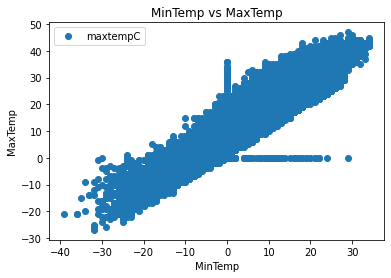

In [42]:
data.plot(x='mintempC', y='maxtempC', style='o')  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('MinTemp')  
plt.ylabel('MaxTemp')  
plt.show()

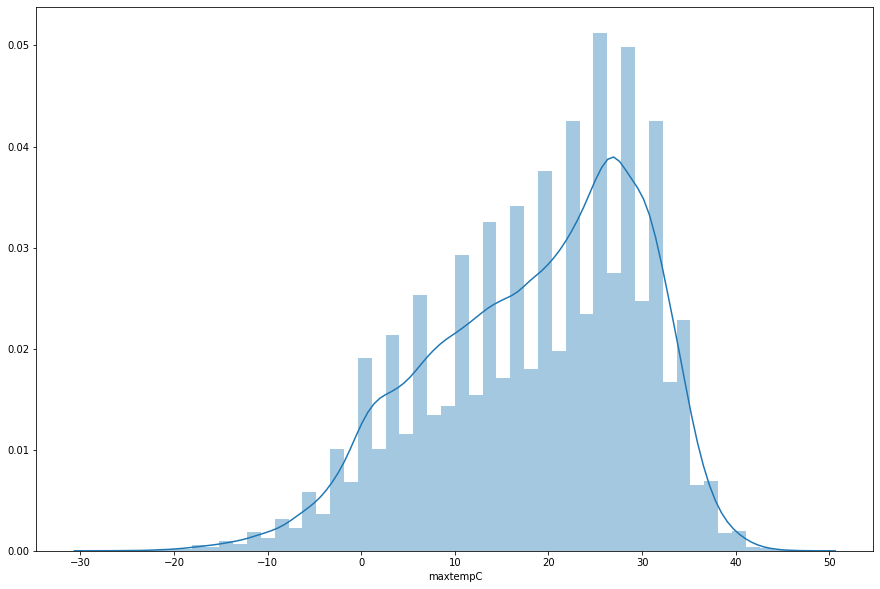

In [43]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(data['maxtempC'])

In [44]:
# Get baseline for temperature
baseline_temp = sum(data['maxtempC']) / data.shape[0]
baseline_temp

18.735927750410507

In [45]:
# # Separate data into target and features
# X = data.drop(['location','maxtempC','date_time'], axis=1)
# y = data['maxtempC']

In [46]:
# # train test split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [47]:
# # Fit Linear Regression Model to Data
# LinReg = LinearRegression()
# LinReg.fit(X_train, y_train)

In [48]:
# y_pred = LinReg.predict(X_test)

In [49]:
# df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# df

In [50]:
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))